# Welcome the challenge notebook 
--- 


In this challenge, you will work with a dataset provided by an HR manager who wants to predict which employees are at risk of leaving the company. The dataset contains four key performance indicators (KPIs) related to each employee. Your task is to use PySpark to build a machine learning model that can predict employee attrition and to identify which KPI is most strongly associated with attrition in this company.

- Please note that the dataset is already clean and ready to be modeled. 
- The dataset only contains numerical features.

Installing pyspark

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pyspark

Importing the needed modules and creating the spark session

In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pyspark

In [21]:
# importing spark session
from pyspark.sql import SparkSession
# data visualization modules 
import matplotlib.pyplot as plt
import plotly.express as px 
# pandas module 
import pandas as pd

# pyspark data preprocessing modules
from pyspark.ml.feature import  VectorAssembler, StandardScaler,StringIndexer

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# creating the spark session
spark = SparkSession.builder.appName("Challenge").getOrCreate()
spark

In [6]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline

Loading the `Challenge_dataset.csv` file

In [7]:
data = spark.read.format('csv').option('header',True).option('inferSchema',True).load('Datasets/Challenge_dataset.csv')
data.show(5)

+----------+------------------+-------------------+-------------------+-------------------+---------------+
|EmployeeID|              KPI1|               KPI2|               KPI3|               KPI4|CurrentEmployee|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
|         0|1.4347155493478079| 0.8445778971189396| 1.2907117554310856|-1.4201273531837943|              1|
|         1|0.8916245735832885| 0.8308158727699302| 1.0779750584283363|-1.0598957663940176|              1|
|         2|-0.891158353098296|-0.9469681237741348|-1.1825287909456643| 1.1269205082112577|              0|
|         3|1.2797294893867808| 1.6690888870054317| 1.9769417044649022| -1.797525912345404|              1|
|         4|0.2576789316661615|0.34201906896710577|0.40342208520171396|-0.3653830886145554|              1|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
only showing top 5 rows



In [8]:
data.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- KPI1: double (nullable = true)
 |-- KPI2: double (nullable = true)
 |-- KPI3: double (nullable = true)
 |-- KPI4: double (nullable = true)
 |-- CurrentEmployee: integer (nullable = true)



Create the numerical feature vector using `Vector Assembler`.

Hint: The numerical input features are the KPIs.

In [9]:
# write your code here
num_features = [col for col in data.columns if col.startswith('KPI')]
vecAssemb = VectorAssembler(inputCols = num_features, outputCol="num_feat_vector")
data = vecAssemb.transform(data)

In [10]:
data.show(5)

+----------+------------------+-------------------+-------------------+-------------------+---------------+--------------------+
|EmployeeID|              KPI1|               KPI2|               KPI3|               KPI4|CurrentEmployee|     num_feat_vector|
+----------+------------------+-------------------+-------------------+-------------------+---------------+--------------------+
|         0|1.4347155493478079| 0.8445778971189396| 1.2907117554310856|-1.4201273531837943|              1|[1.43471554934780...|
|         1|0.8916245735832885| 0.8308158727699302| 1.0779750584283363|-1.0598957663940176|              1|[0.89162457358328...|
|         2|-0.891158353098296|-0.9469681237741348|-1.1825287909456643| 1.1269205082112577|              0|[-0.8911583530982...|
|         3|1.2797294893867808| 1.6690888870054317| 1.9769417044649022| -1.797525912345404|              1|[1.27972948938678...|
|         4|0.2576789316661615|0.34201906896710577|0.40342208520171396|-0.3653830886145554|      

Apply `Standard Scaler` to the numerical feature vector

In [11]:
# write your code here
scaler = StandardScaler(inputCol = 'num_feat_vector', outputCol = 'num_feat_scaled', withStd=True, withMean=True)
data = scaler.fit(data).transform(data)

In [12]:
data.show(3)

+----------+------------------+-------------------+-------------------+-------------------+---------------+--------------------+--------------------+
|EmployeeID|              KPI1|               KPI2|               KPI3|               KPI4|CurrentEmployee|     num_feat_vector|     num_feat_scaled|
+----------+------------------+-------------------+-------------------+-------------------+---------------+--------------------+--------------------+
|         0|1.4347155493478079| 0.8445778971189396| 1.2907117554310856|-1.4201273531837943|              1|[1.43471554934780...|[1.08218890600599...|
|         1|0.8916245735832885| 0.8308158727699302| 1.0779750584283363|-1.0598957663940176|              1|[0.89162457358328...|[0.67319507945975...|
|         2|-0.891158353098296|-0.9469681237741348|-1.1825287909456643| 1.1269205082112577|              0|[-0.8911583530982...|[-0.6693925230286...|
+----------+------------------+-------------------+-------------------+-------------------+---------

Split the data into train and test sets

In [13]:
# write your code here
train, test = data.randomSplit([0.7,0.3], seed=100)

In [14]:
train.count(), test.count()

(2813, 1187)

Train your Decision Tree model. Use `maxDepth = 3`

In [15]:
# write your code here
dt = DecisionTreeClassifier(featuresCol="num_feat_scaled", labelCol="CurrentEmployee",
                           maxDepth=3)
model = dt.fit(train)

Perform the prediction on the test set and calculate the accuracy using `BinaryClassificationEvaluator`

In [16]:
# write your code here
pred_test = model.transform(test)
evalue = BinaryClassificationEvaluator(labelCol = "CurrentEmployee")
auc_test = evalue.evaluate(pred_test,{evalue.metricName:"areaUnderROC"})
auc_test

0.8901179103290812

Apply the hyper paramter tuning to find the proper `maxDepth` for your decision tree from the `candidates` list.

In [22]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'num_feat_scaled', labelCol = 'CurrentEmployee', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol='CurrentEmployee')
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol='CurrentEmployee')
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  



candidates = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# write your code here
test_accs, train_accs = evaluate_dt(candidates)

Use a line chart to visualize the training and testing accuracy. <br>

Hint: To visualize your data, convert the PySpark dataframe to pandas dataframe.

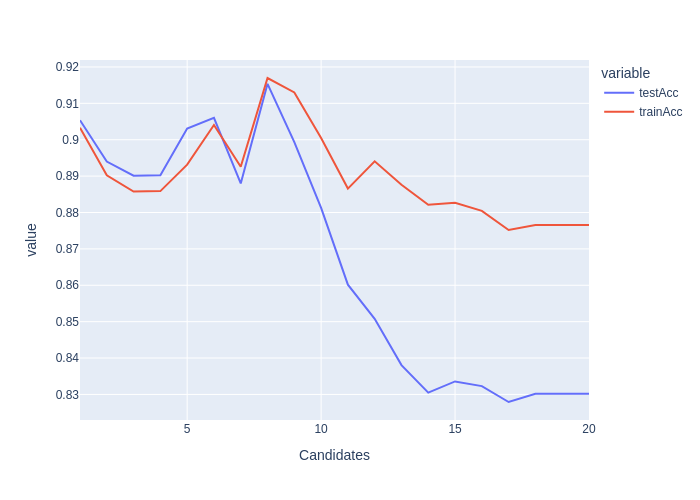

In [24]:
# write your code here
df = pd.DataFrame()
df['Candidates'] = candidates
df['testAcc'] = test_accs
df['trainAcc'] = train_accs
px.line(df, x='Candidates', y=['testAcc','trainAcc']).show(renderer='png')

Train the decision tree using the proper `maxDepth` parameter.  

In [19]:
# write your code here
dt = DecisionTreeClassifier(featuresCol="num_feat_scaled", labelCol="CurrentEmployee",
                           maxDepth=6)
model = dt.fit(train)

Use the `Feature Importance` to find the most important factor for the employee attrition using a barchart.

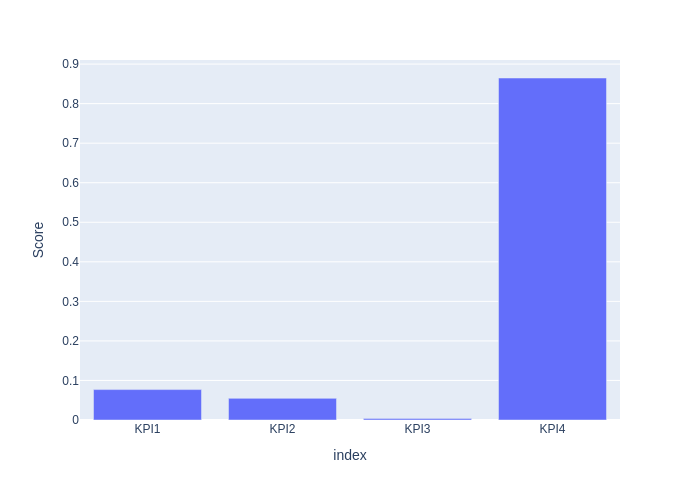

In [23]:
# write your code here
feat_importance = model.featureImportances
scores = []
for i, score in enumerate(feat_importance):
    scores.append(score)
feat_Importance = pd.DataFrame(scores, columns=['Score'], index=num_features)
px.bar(feat_Importance,y="Score").show(renderer='png')